In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [2]:
import math
import pandas as pd
from datetime import date
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass
import json

In [3]:
INITIAL_CONDITIONS_FILE = "./data/initial_conditions.json"
PAST_OVERPAYMENTS_FILE = "./data/past_overpayments.csv"
initial_conditions = json.load(open("./data/initial_conditions.json"))
START_DATE = date.fromisoformat(initial_conditions["start_date"])
MORTGAGE_AMOUNT = initial_conditions["mortgage_amount"]
INTEREST_RATE = initial_conditions["interest_rate"]
MONTHLY_PAYMENT = initial_conditions["monthly_payment"]

In [4]:
def months_diff(first_date, last_date) -> int:
    delta = relativedelta(last_date, first_date)
    return (delta.years * 12) + delta.months

In [5]:
@dataclass(order=True)
class Payment:
    date: date  # keep date as first field (field order determines results of comparisons for sorting)
    amount: float

    def __add__(self, other: "Payment") -> "Payment":
        if not isinstance(other, self.__class__):
            raise TypeError("Must be same class")

        return Payment(
            self.date if self.date == other.date else None, self.amount + other.amount
        )

    def __radd__(self, value: int) -> "Payment":
        # To enable using sum([Payment, Payment]) https://stackoverflow.com/a/1218735
        return Payment(self.date, self.amount + value)

In [6]:
class PaymentSchema:
    def for_date(self, date: date) -> float:
        raise NotImplementedError

    def all(self) -> list[Payment]:
        raise NotImplementedError

In [7]:
class PastOverpayments:
    overpayments = {
        payment["date"]: Payment(payment["date"], payment["amount"])
        for payment in pd.read_csv(
            PAST_OVERPAYMENTS_FILE, parse_dates=["date"]
        ).to_dict("records")
    }

    def for_date(self, date: date) -> float:
        if not date in self.overpayments:
            return Payment(date, 0.0)
        return self.overpayments[date]

    def for_period(self, date_from: date = None, date_to: date = None) -> list[Payment]:
        overpayments = self.overpayments.values()
        if date_from:
            overpayments = [
                overpayment
                for overpayment in overpayments
                if overpayment.date >= date_from
            ]
        if date_to:
            overpayments = [
                overpayment
                for overpayment in overpayments
                if overpayment.date <= date_to
            ]

        return sorted(overpayments)

    def all(self) -> list[Payment]:
        return sorted(self.overpayments.values())

In [8]:
@dataclass
class PaymentsInRange:
    start_date: date
    end_date: date
    amount: float

    def for_date(self, date: date) -> float:
        if (
            (self.start_date and date < self.start_date)
            or (self.end_date and date > self.end_date)
            or date.day != 1
        ):
            return Payment(date, 0.0)

        return Payment(date, self.amount)

    def all(self) -> list[Payment]:
        return [
            Payment(self.start_date + relativedelta(months=month_count), self.amount)
            for month_count in range(months_diff(self.start_date, self.end_date) + 1)
        ]

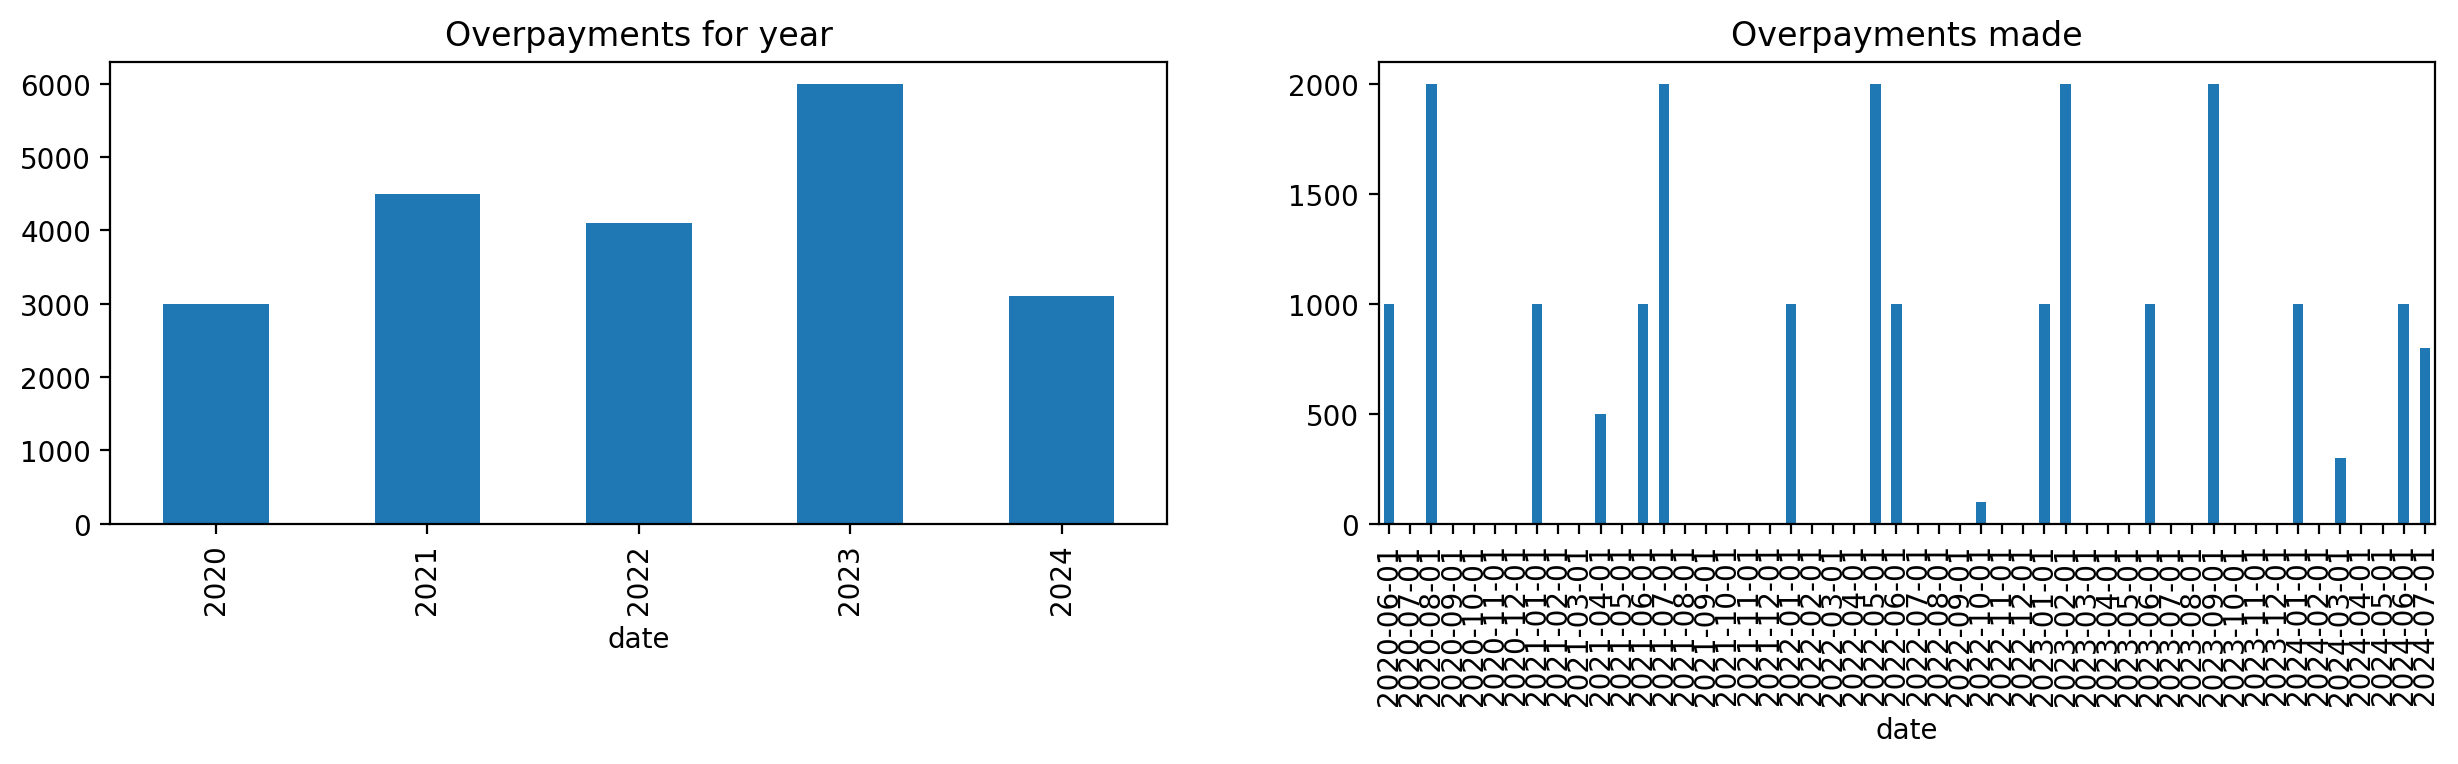

'Average overpayment (mean, median): 414.00, 0.00'

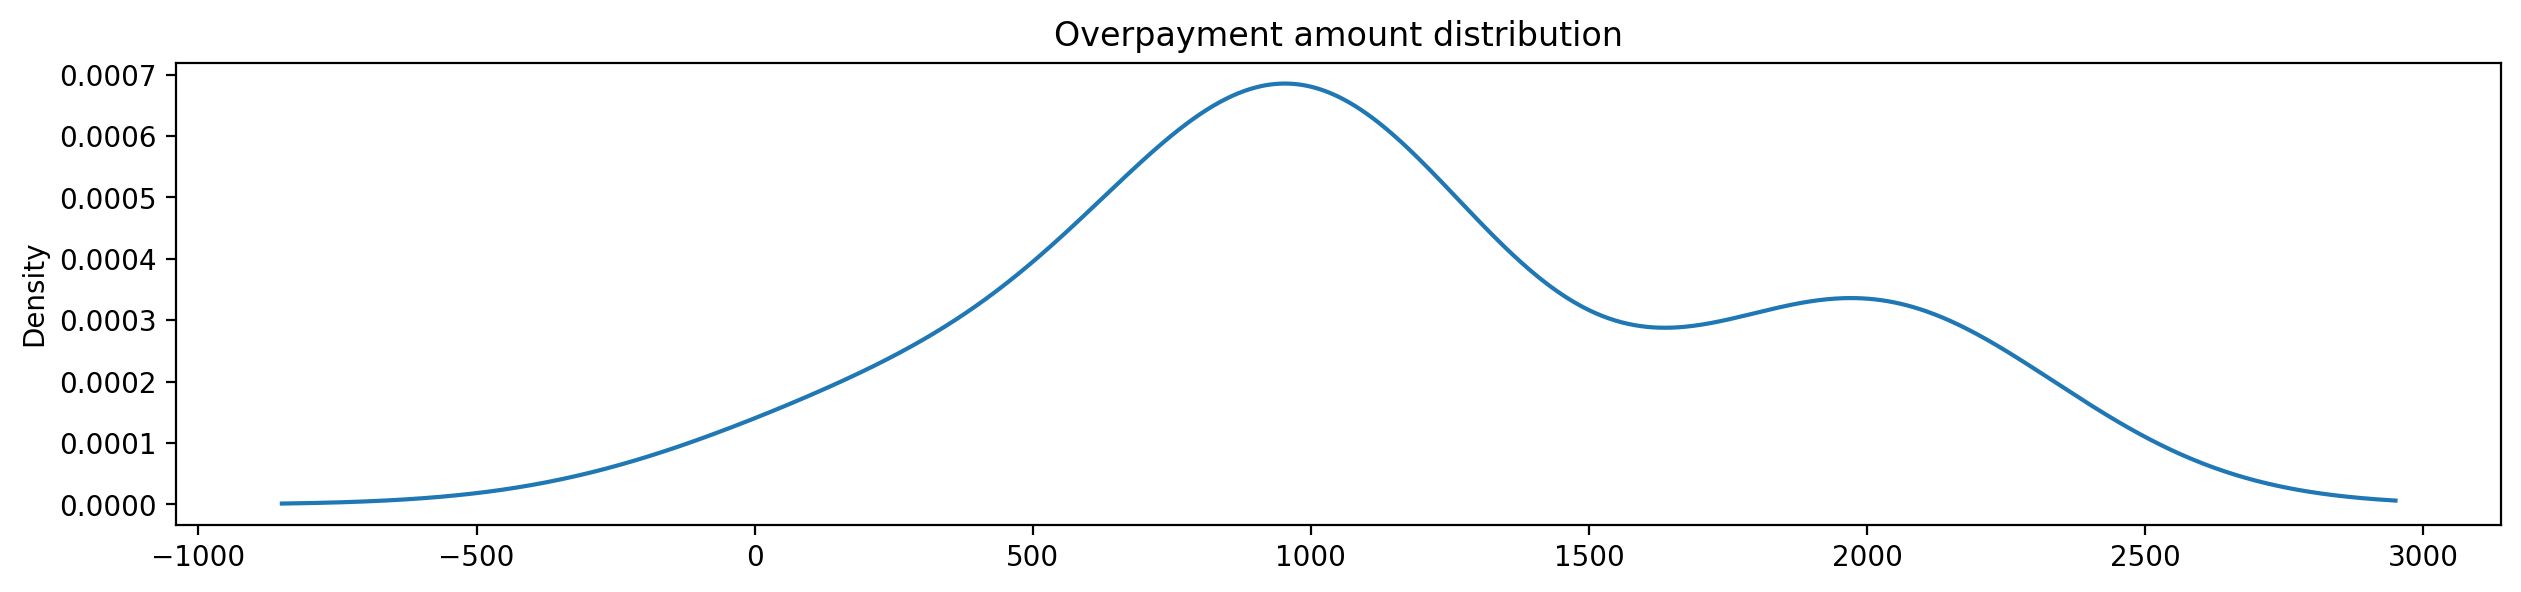

In [9]:
past_overpayments_series = (
    pd.DataFrame(PastOverpayments().all())
    .set_index("date")
    .reindex(
        pd.date_range(
            min(PastOverpayments().all()).date,
            max(PastOverpayments().all()).date,
            freq="MS",
            inclusive="both",
        ).date,
        method="nearest",
        fill_value=0,
        tolerance=timedelta(days=3),
    )
    .amount
)

fig, axes = plt.subplots(nrows=1, ncols=2)
yearly_overpayment = pd.DataFrame(PastOverpayments().all())
yearly_overpayment["date"] = pd.to_datetime(yearly_overpayment.date)
yearly_overpayment = yearly_overpayment.groupby(
    yearly_overpayment.date.dt.year
).amount.sum()
yearly_overpayment.plot.bar(ax=axes[0], title="Overpayments for year", figsize=(15, 3))
past_overpayments_series.plot.bar(
    title="Overpayments made", figsize=(15, 3), ax=axes[1]
)
plt.show()

past_overpayments_series[past_overpayments_series != 0].plot.kde(
    title="Overpayment amount distribution", figsize=(15, 3)
)
p25_overpayment = past_overpayments_series.quantile(0.25)
p75_overpayment = past_overpayments_series.quantile(0.75)
mean_overpayment = past_overpayments_series.mean()
median_overpayment = past_overpayments_series.median()
f"Average overpayment (mean, median): {mean_overpayment:.2f}, {median_overpayment:.2f}"

In [10]:
@dataclass
class Amortization:
    date: date
    amount: float
    interest_payed: float
    outstanding_payed: float
    outstanding: float

In [11]:
def simulate(
    payment_schemas: list[PaymentSchema] = [],
    outstanding=MORTGAGE_AMOUNT,
    first_date=START_DATE,
):
    interest_rate = INTEREST_RATE
    payment_date = first_date

    while outstanding > 0:
        payment = sum(schema.for_date(payment_date) for schema in payment_schemas)
        interest_payed = outstanding * interest_rate / 12
        outstanding_payed = payment.amount - interest_payed
        outstanding = outstanding - outstanding_payed

        yield Amortization(
            date=payment_date,
            amount=payment.amount,
            interest_payed=interest_payed,
            outstanding_payed=outstanding_payed,
            outstanding=outstanding,
        )

        payment_date = payment_date + relativedelta(months=1)

In [12]:
def payment_table(monthly_overpayment_amount):
    return pd.DataFrame(
        [
            x
            for x in simulate(
                payment_schemas=[
                    PastOverpayments(),  # Past overpayments
                    PaymentsInRange(
                        start_date=START_DATE, end_date=None, amount=MONTHLY_PAYMENT
                    ),  # All installments
                    PaymentsInRange(
                        start_date=date.today(),
                        end_date=None,
                        amount=monthly_overpayment_amount,
                    ),  # Future overpayments
                ]
            )
        ]
    ).set_index("date")

<Axes: xlabel='date'>

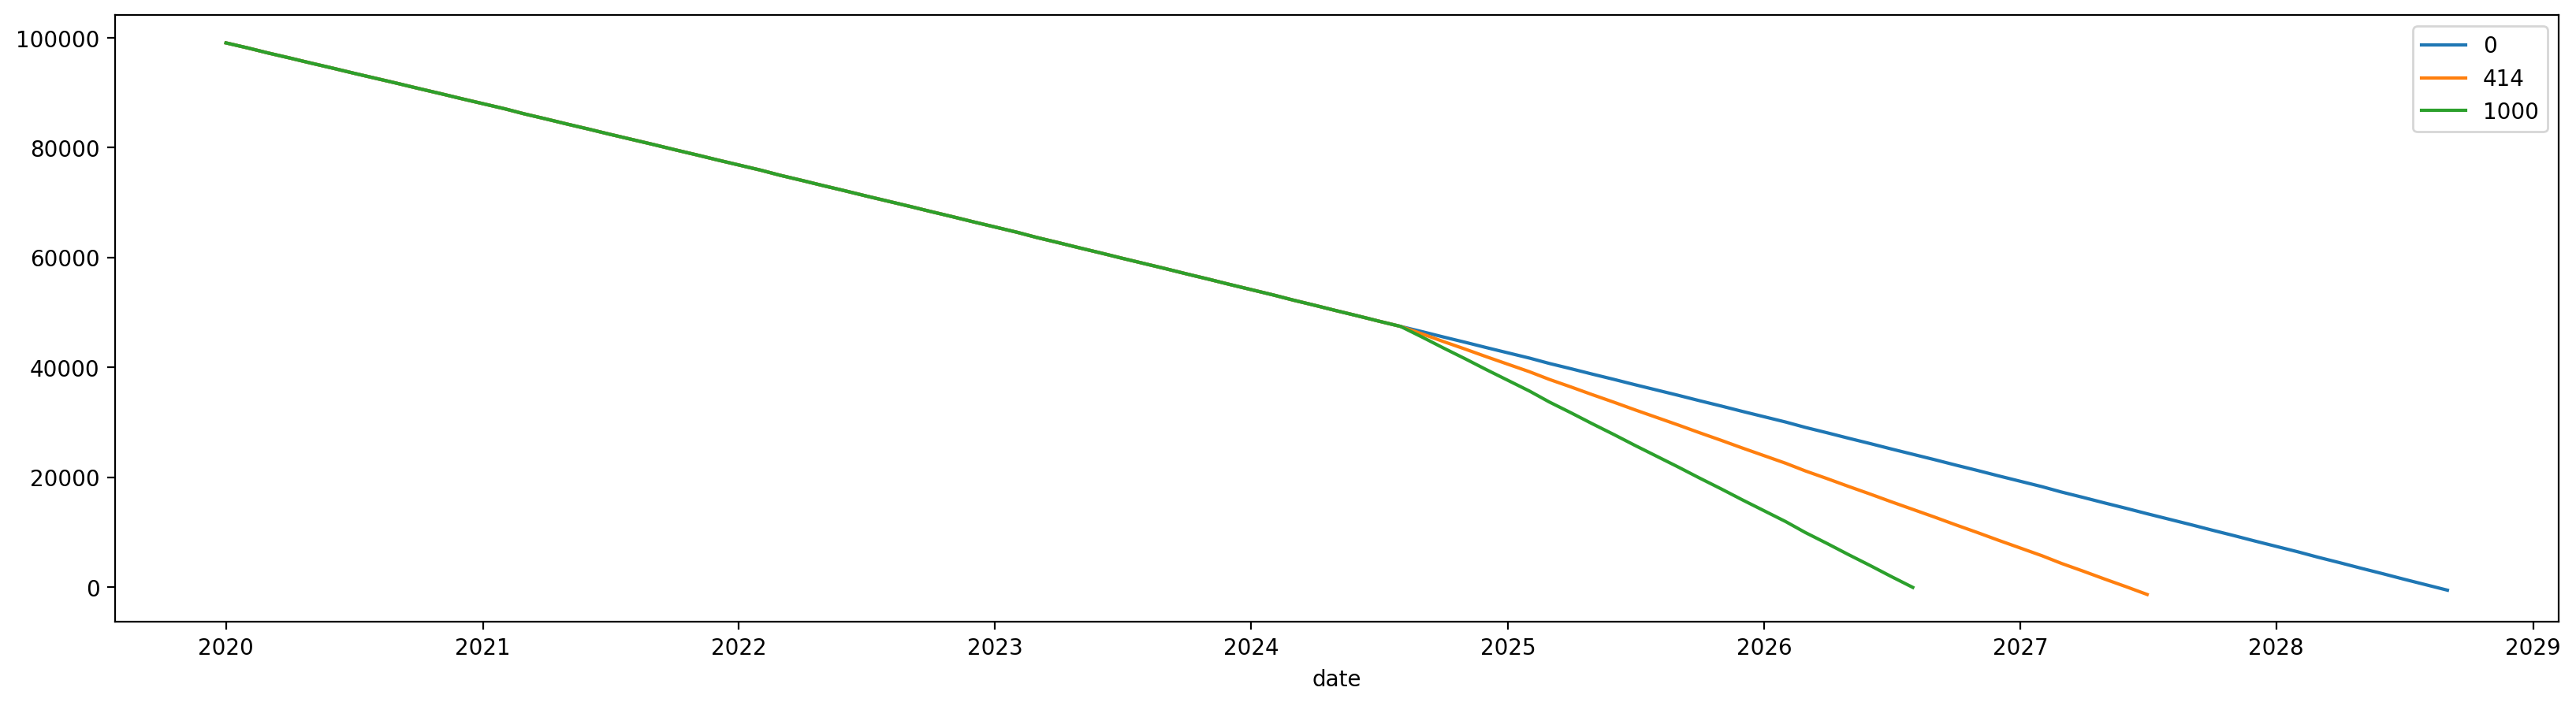

In [13]:
overpayment_amounts_for_simulations = sorted(
    [
        int(n)
        for n in [
            p25_overpayment,
            mean_overpayment,
            median_overpayment,
            p75_overpayment,
        ]
    ]
)
simulations = {
    amount: payment_table(amount) for amount in overpayment_amounts_for_simulations
}

pd.concat(
    (
        simulation.outstanding.rename(amount)
        for amount, simulation in simulations.items()
    ),
    axis=1,
).plot(figsize=(20, 5))

In [14]:
time_since_loan_start = relativedelta(date.today(), START_DATE)

simulation = simulations[int(median_overpayment)]
current_outstanding = simulation[simulation.index <= date.today()].outstanding[-1]

print(
    f"""
Loan started in {START_DATE}, {time_since_loan_start.years} years and {time_since_loan_start.months} months ago.

So far, {(MORTGAGE_AMOUNT - current_outstanding):,.2f} has been payed. {current_outstanding:,.2f} to go.

"""
)

for amount, simulation in simulations.items():
    last_payment_date = simulation.outstanding[simulation.outstanding <= 0].index[0]

    time_to_last_payment = relativedelta(last_payment_date, date.today())
    years_to_payment = time_to_last_payment.years
    remainder_months = time_to_last_payment.months

    print(
        f"""For {amount}:
Last payment will be on {last_payment_date}.
Thats {years_to_payment} years and {remainder_months} months from now.
"""
    )


Loan started in 2020-01-01, 4 years and 7 months ago.

So far, 52,527.56 has been payed. 47,472.44 to go.


For 0:
Last payment will be on 2028-09-01.
Thats 4 years and 0 months from now.

For 414:
Last payment will be on 2027-07-01.
Thats 2 years and 10 months from now.

For 1000:
Last payment will be on 2026-08-01.
Thats 1 years and 11 months from now.



/var/folders/vf/yr8tscw16hbcb2gnc4myhfv00000gn/T/ipykernel_99392/15840744.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_outstanding = simulation[simulation.index <= date.today()].outstanding[-1]


<Axes: title={'center': 'Total interest payed by overpayment amount'}, xlabel='monthly overpayment'>

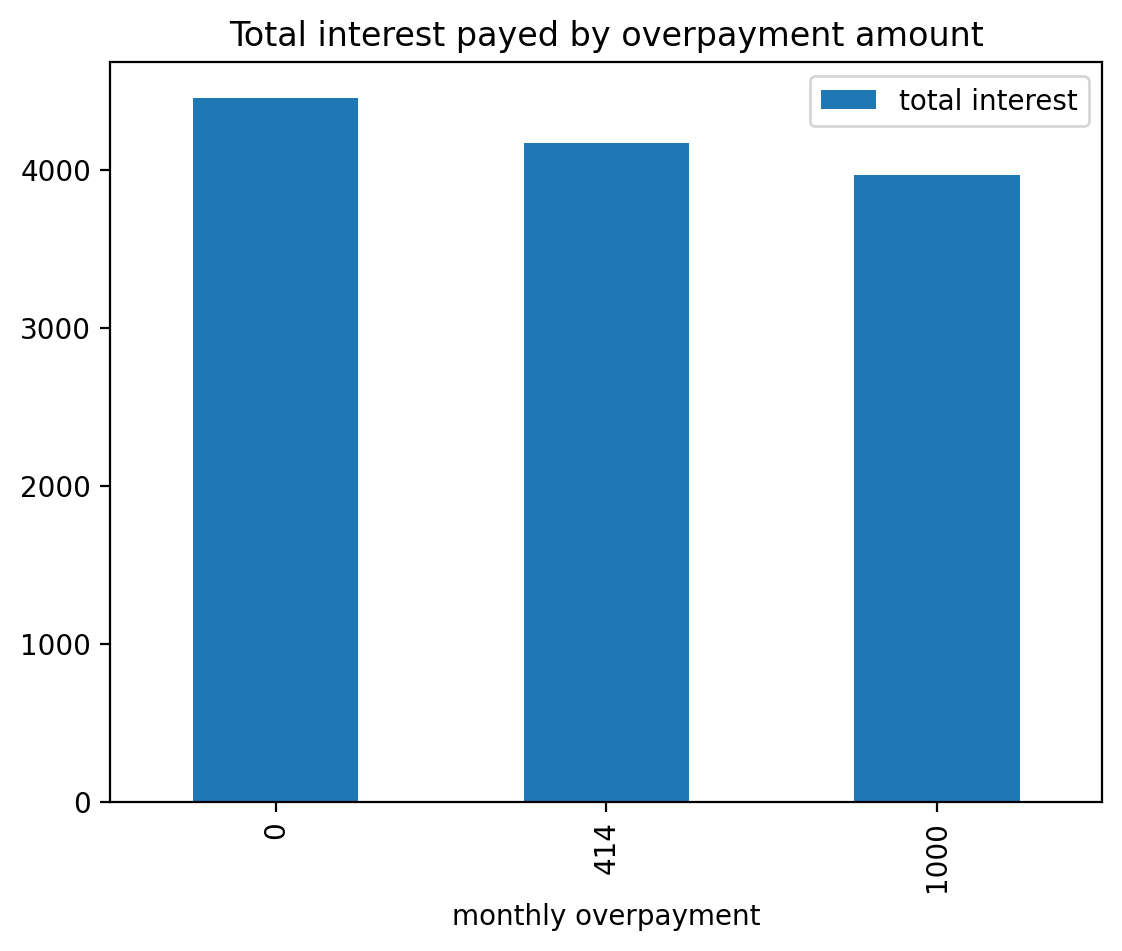

In [15]:
pd.DataFrame(
    [
        (amount, simulation.interest_payed.sum())
        for amount, simulation in simulations.items()
    ],
    columns=["monthly overpayment", "total interest"],
).set_index("monthly overpayment").plot.bar(
    title="Total interest payed by overpayment amount"
)